In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from math import ceil
from datetime import datetime, timedelta

In [140]:
df = pd.read_csv('dataset_mood_smartphone.csv')

In [141]:
"""
Remove NaN values
"""
df = df.dropna()

In [142]:
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date
df['hour'] = df['time'].dt.hour
unique_variables = df['variable'].unique()
participants = df['id'].unique()
days = df['date'].unique()

In [143]:
active_subjects_day = df.groupby(['date'])['id'].unique().reset_index()
active_subjects_hour = df.groupby(['hour'])['id'].unique().reset_index()

In [144]:
"""
Average data for each day:
"""
non_time_variables = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity']
df_time = df[~df['variable'].isin(non_time_variables)]

# For time variables, we take the mean of each day averaged over the active participants of the corresponding day
daily_avg_df_time = df_time.groupby(['date', 'variable'])['value'].sum().reset_index()
daily_avg_df_time['value'] = daily_avg_df_time['value'] / len(active_subjects_day['date'])

# For non-time variables, we take the mean of all the inputs for each hour
df_non_time = df[df['variable'].isin(non_time_variables)]
daily_avg_df_non_time = df_non_time.groupby(['date', 'variable'])['value'].mean().reset_index()

# Merges the two dataframes
daily_avg_df = pd.concat([daily_avg_df_non_time, daily_avg_df_time], ignore_index=True)

In [145]:
# print(len(unique_variables))
# print(len(participants))
# print(len(days))
# for variable in unique_variables:
#     print(len(daily_avg_df['variable'] == variable))
# print(daily_avg_df[daily_avg_df['variable'] == 'mood'])

19
27
113
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
           date variable     value
2    2014-02-26     mood  6.250000
5    2014-02-27     mood  6.333333
8    2014-03-04     mood  7.000000
11   2014-03-05     mood  7.166667
14   2014-03-06     mood  7.222222
..          ...      ...       ...
361  2014-06-04     mood  7.000000
365  2014-06-05     mood  7.000000
369  2014-06-06     mood  7.500000
372  2014-06-07     mood  8.000000
376  2014-06-08     mood  6.500000

[98 rows x 3 columns]


Text(0.5, 1.0, 'Correlation Heatmap of Variables')

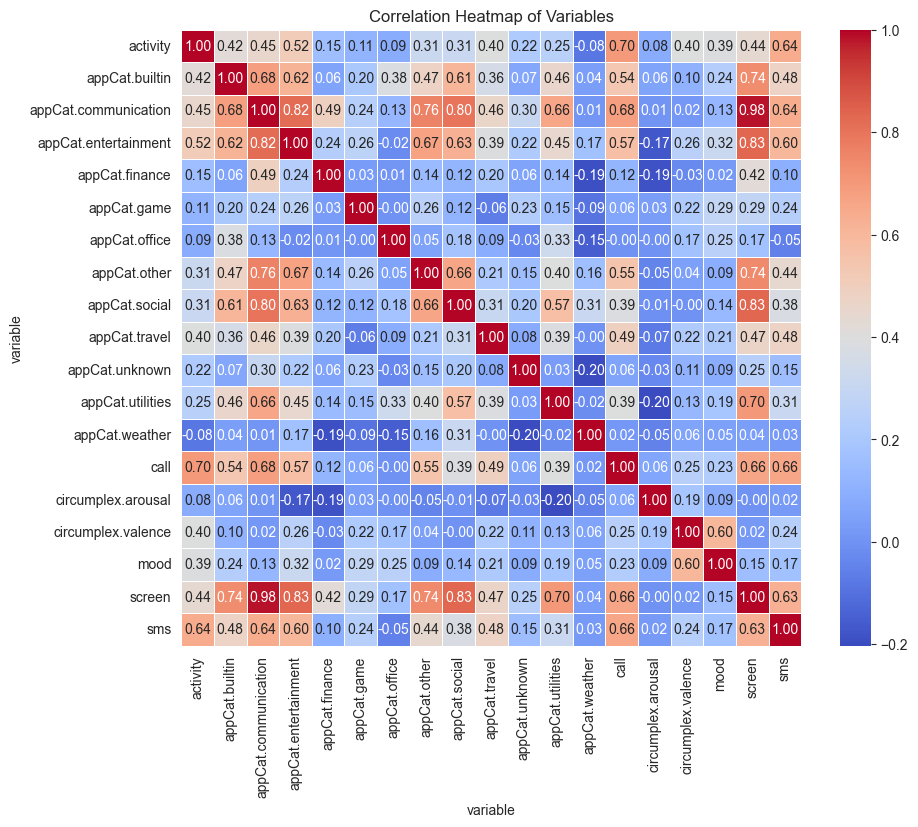

In [147]:
"""
Corr. heatmap, index on date
"""
df_pivoted = daily_avg_df.pivot_table(index='date', columns='variable', values='value')
corr_matrix = df_pivoted.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Variables')

In [154]:
"""
Average data for each hour
"""
non_time_variables = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity']
df_time = df[~df['variable'].isin(non_time_variables)]

# For time variables, we take the mean of each hour averaged over the active participants of the corresponding hour
hourly_avg_df_time = df_time.groupby(['hour', 'variable'])['value'].sum().reset_index()
hourly_avg_df_time['value'] = daily_avg_df_time['value'] / len(active_subjects_hour['hour'])

# For non-time variables, we take the mean of all the inputs of each day
df_non_time = df[df['variable'].isin(non_time_variables)]
hourly_avg_df_non_time = df_non_time.groupby(['hour', 'variable'])['value'].mean().reset_index()

# Merges the two dataframes
hourly_avg_df = pd.concat([hourly_avg_df_non_time, hourly_avg_df_time], ignore_index=True)

Text(0.5, 1.0, 'Correlation Heatmap of Variables')

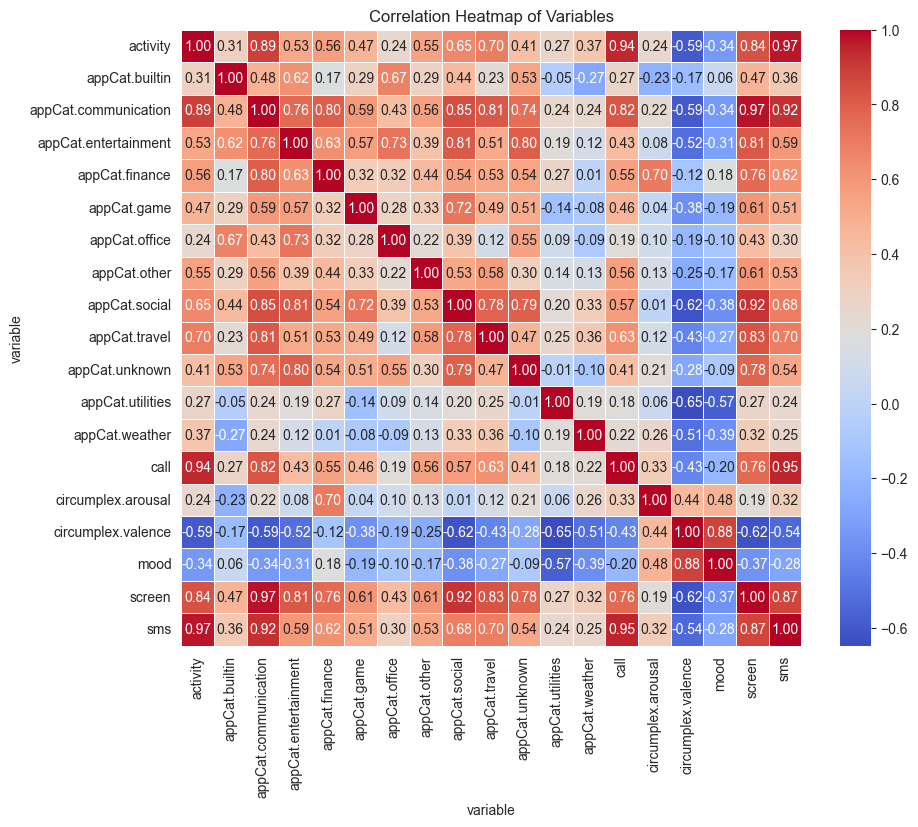

In [155]:
"""
Corr. heatmap, index on hour
"""
df_pivoted = hourly_avg_df.pivot_table(index='hour', columns='variable', values='value')
corr_matrix = df_pivoted.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Variables')

In [161]:
"""
Calculate end and start date of data collection on each variable
Conclusion: There are only 49 days of which between the latest starting date and the earliest stop date of measuring the predictors.
"""
start_dates = []
end_dates = []

for variable in unique_variables:
    var_df = df.loc[df['variable'] == variable]
    start_date = var_df['date'].min()
    start_dates.append(start_date)
    end_date = var_df['date'].max()
    end_dates.append(end_date)
    print(f'var: {variable}, start: {start_date}, end: {end_date}')

max_start_date = max(start_dates)
min_end_date = min(end_dates)

print('')
print(f'Latest start date: {max_start_date}, earliest end date: {min_end_date}')

var: mood, start: 2014-02-26, end: 2014-06-08
var: circumplex.arousal, start: 2014-02-26, end: 2014-06-08
var: circumplex.valence, start: 2014-02-26, end: 2014-06-08
var: activity, start: 2014-03-17, end: 2014-06-09
var: screen, start: 2014-03-13, end: 2014-06-08
var: call, start: 2014-02-17, end: 2014-06-06
var: sms, start: 2014-02-17, end: 2014-06-07
var: appCat.builtin, start: 2014-03-13, end: 2014-06-08
var: appCat.communication, start: 2014-03-13, end: 2014-06-08
var: appCat.entertainment, start: 2014-03-13, end: 2014-06-02
var: appCat.finance, start: 2014-03-15, end: 2014-05-09
var: appCat.game, start: 2014-03-20, end: 2014-05-13
var: appCat.office, start: 2014-03-15, end: 2014-05-28
var: appCat.other, start: 2014-03-13, end: 2014-06-08
var: appCat.social, start: 2014-03-13, end: 2014-06-08
var: appCat.travel, start: 2014-03-14, end: 2014-06-05
var: appCat.unknown, start: 2014-03-14, end: 2014-05-30
var: appCat.utilities, start: 2014-03-13, end: 2014-06-06
var: appCat.weather, st

In [156]:
# for variable in unique_variables:
#     print(len(hourly_avg_df['variable'] == variable))
# print(daily_avg_df[hourly_avg_df['variable'] == 'mood'])

442
442
442
442
442
442
442
442
442
442
442
442
442
442
442
442
442
442
442
    hour variable     value
3      0     mood  6.733333
7      1     mood  7.250000
11     2     mood  7.666667
15     3     mood  7.666667
19     4     mood  9.000000
25     7     mood  5.500000
29     8     mood  6.908046
33     9     mood  6.790411
37    10     mood  6.774775
41    11     mood  6.912568
45    12     mood  7.007246
49    13     mood  6.877698
53    14     mood  6.953642
57    15     mood  6.968447
61    16     mood  7.013889
65    17     mood  7.012270
69    18     mood  7.024814
73    19     mood  7.194245
77    20     mood  7.125000
81    21     mood  7.153226
85    22     mood  7.150000
89    23     mood  7.100000
